<a href="https://colab.research.google.com/github/vkthakur90/jupyter_notebooks/blob/master/Classical_Image_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import google.colab.files as gcf

In [2]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [3]:
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import tensorflow.keras.models as tfkm
import tensorflow.keras.utils as tfku

In [4]:
!ls

uploaded = gcf.upload()

for k, v in uploaded.items():
    with open(k, 'wb') as f:
        f.write(v)

!ls

sample_data  sid_kiara.jpg


sample_data  sid_kiara.jpg


In [5]:
img = tfku.load_img('sid_kiara.jpg', target_size = [480, 640], keep_aspect_ratio = True)
img_arr = np.uint8(tfku.img_to_array(img))

In [6]:
@tfku.register_keras_serializable()
class UniformConv(tfkl.Layer):
    def __init__(self):
        super().__init__()

    def get_config(self):
        return super().get_config()

    def build(self, input_shape):
        inp = tfkl.Input(input_shape[1:])
        filter_layer = tfkl.DepthwiseConv2D((3, 3), use_bias = False, padding = 'same')

        filter_array = np.array([
            [1/9, 1/9, 1/9],
            [1/9, 1/9, 1/9],
            [1/9, 1/9, 1/9]
        ])[..., np.newaxis, np.newaxis]


        x = inp
        x = tfkl.Lambda(lambda t: tf.split(t, num_or_size_splits = input_shape[-1], axis = -1))(x)
        x = [filter_layer(t) for t in x]
        x = tfkl.Concatenate(axis = -1)(x)

        out = x

        filter_layer.set_weights([filter_array])

        filter_layer.trainable = False

        self.forward = tfkm.Model(inputs = [inp], outputs = [out])

    def call(self, input):
        return self.forward(input)

In [7]:
@tfku.register_keras_serializable()
class GaussianConv(tfkl.Layer):
    def __init__(self):
        super().__init__()

    def get_config(self):
        return super().get_config()

    def build(self, input_shape):
        inp = tfkl.Input(input_shape[1:])
        gaussian = tfkl.DepthwiseConv2D((3, 3), use_bias = False, padding = 'same')

        gaussian_filter = np.array([
            [1/16, 2/16, 1/16],
            [2/16, 4/16, 2/16],
            [1/16, 2/16, 1/16]
        ])[..., np.newaxis, np.newaxis]


        x = inp
        x = tfkl.Lambda(lambda t: tf.split(t, num_or_size_splits = input_shape[-1], axis = -1))(x)
        x = [gaussian(t) for t in x]
        x = tfkl.Concatenate(axis = -1)(x)

        out = x

        gaussian.set_weights([gaussian_filter])

        gaussian.trainable = False

        self.forward = tfkm.Model(inputs = [inp], outputs = [out])

    def call(self, input):
        return self.forward(input)

In [8]:
@tfku.register_keras_serializable()
class LaplacianConv(tfkl.Layer):
    def __init__(self):
        super().__init__()

    def get_config(self):
        return super().get_config()

    def build(self, input_shape):
        inp = tfkl.Input(input_shape[1:])
        laplacian = tfkl.DepthwiseConv2D((3, 3), use_bias = False, padding = 'same')

        laplacian_filter = np.array([
            [ 0.0, -1.0,  0.0],
            [-1.0,  4.0, -1.0],
            [ 0.0, -1.0,  0.0]
        ])[..., np.newaxis, np.newaxis]

        x = inp
        x = tfkl.Lambda(lambda t: tf.split(t, num_or_size_splits = input_shape[-1], axis = -1))(x)
        x = [laplacian(t) for t in x]
        x = tfkl.Concatenate(axis = -1)(x)

        out = x

        laplacian.set_weights([laplacian_filter])

        laplacian.trainable = False


        self.forward = tfkm.Model(inputs = [inp], outputs = [out])

    def call(self, input):
        return self.forward(input)

In [9]:
@tfku.register_keras_serializable()
class DownPoolLayer(tfkl.Layer):
    def __init__(self):
        super().__init__()

    def get_config(self):
        return super().get_config()

    def build(self, input_shape):
        inp = tfkl.Input(input_shape[1:])

        x = inp

        z1 = tfkl.MaxPool2D((2, 2))(x)
        z2 = tfkl.Lambda(lambda t: -t)(x)
        z2 = tfkl.MaxPool2D((2, 2))(z2)
        z2 = tfkl.Lambda(lambda t: -t)(z2)
        y = tfkl.Concatenate(axis = -1)([z1, z2])

        out = y

        self.forward = tfkm.Model(inputs = [inp], outputs = [out])

    def call(self, input):
        return self.forward(input)

In [10]:
@tfku.register_keras_serializable()
class EdgeDetectionLayer(tfkl.Layer):
    def __init__(self):
        super().__init__()

    def get_config(self):
        return super().get_config()

    def build(self, input_shape):
        inp = tfkl.Input(input_shape[1:])

        x = inp

        x = GaussianConv()(x)
        x = LaplacianConv()(x)
        x = tfkl.ReLU()(x)
        x = UniformConv()(x)

        out = x

        self.forward = tfkm.Model(inputs = [inp], outputs = [out])

    def call(self, input):
        return self.forward(input)

In [11]:
@tfku.register_keras_serializable()
class PyramidConvFeatures(tfkl.Layer):
    def __init__(self):
        super().__init__()

    def get_config(self):
        return super().get_config()

    def build(self, input_shape):
        inp = tfkl.Input(input_shape[1:])

        x = inp
        x = tfkl.Rescaling(scale = 1/127.5, offset = -1)(x)

        x0 = EdgeDetectionLayer()(x)
        x = DownPoolLayer()(x)

        x1 = EdgeDetectionLayer()(x)
        x = DownPoolLayer()(x)

        x2 = EdgeDetectionLayer()(x)
        x = DownPoolLayer()(x)

        x3 = EdgeDetectionLayer()(x)
        x = DownPoolLayer()(x)

        x4 = EdgeDetectionLayer()(x)
        x = DownPoolLayer()(x)

        x5 = EdgeDetectionLayer()(x)

        x = tfkl.UpSampling2D((2, 2), interpolation = 'nearest')(x5)

        x = tfkl.Concatenate(axis = -1)([x4, x])
        x = tfkl.UpSampling2D((2, 2), interpolation = 'nearest')(x)


        x = tfkl.Concatenate(axis = -1)([x3, x])
        x = tfkl.UpSampling2D((2, 2), interpolation = 'nearest')(x)

        x = tfkl.Concatenate(axis = -1)([x2, x])
        x = tfkl.UpSampling2D((2, 2), interpolation = 'nearest')(x)

        x = tfkl.Concatenate(axis = -1)([x1, x])
        x = tfkl.UpSampling2D((2, 2), interpolation = 'nearest')(x)

        x = tfkl.Concatenate(axis = -1)([x0, x])

        out = x

        self.forward = tfkm.Model(inputs = [inp], outputs = [out])

    def call(self, input):
        return self.forward(input)

In [12]:
model = tfkm.Sequential([
    tfkl.InputLayer([480, 640, 3]),
    PyramidConvFeatures()
])

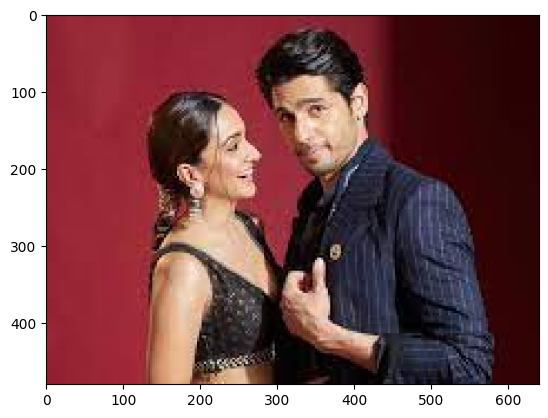

In [13]:
plt.imshow(img_arr)

In [14]:
img_features = model.predict(img_arr[np.newaxis, ...])

1/1 [==============================] - 4s 4s/step


In [15]:
N, H, W, C = img_features.shape
img_features_channels = img_features.reshape([H, W, -1, 3])

min_val = img_features_channels.min(axis = (0, 1, 3), keepdims = True)
max_val = img_features_channels.max(axis = (0, 1, 3), keepdims = True)

norm_img_features = (img_features_channels - min_val) / (max_val - min_val)
norm_img = np.uint8(255.0 * norm_img_features)

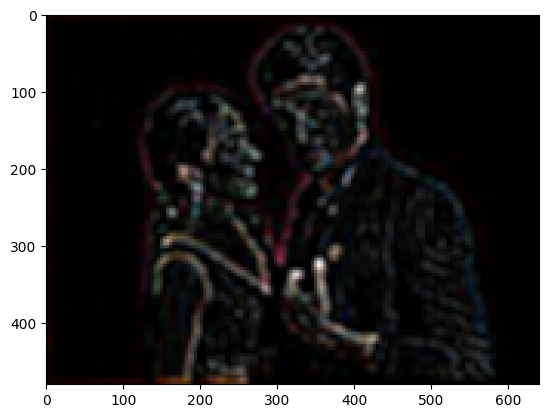

In [16]:
plt.imshow(norm_img[:, :, 5, :])

# Principal Component Analysis

In [17]:
data_df = pd.DataFrame(img_features.reshape([-1, C]), columns = [f'F_{idx + 1:03}' for idx in range(C)])

In [18]:
pca_model = PCA(n_components = 0.95, whiten = True)

In [19]:
pca_features = pca_model.fit_transform(data_df)

In [20]:
pca_features_df = pd.DataFrame(pca_features)

In [21]:
pca_features_img = pca_features.reshape([H, W, -1])

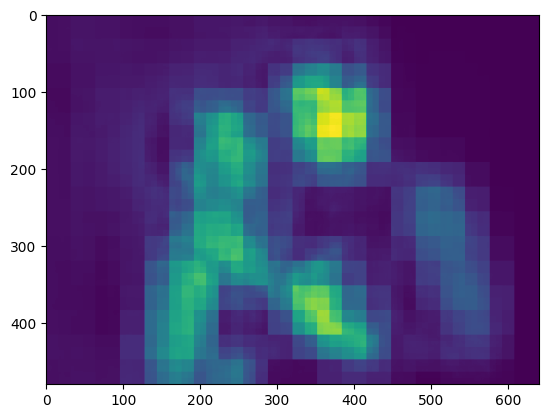

In [22]:
plt.imshow(pca_features_img[:, :, 0])

# Hierarchial Clustering

In [31]:
cluster_model = KMeans(n_clusters = 5, n_init = 'auto')

In [32]:
labels = cluster_model.fit_predict(pca_features_df)

In [33]:
labels_img = labels.reshape([H, W])

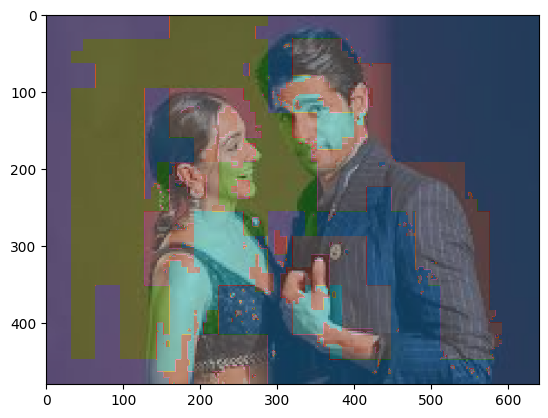

In [34]:
plt.imshow(img_arr)
plt.imshow(labels_img, cmap = 'tab10', alpha = 0.5)